## PREPROCESSING DATA

[Source](https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews/data)

[sentiment-analysis-on-movie-reviews]

In [5]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()

In [6]:
api.authenticate()

In [9]:
api.competition_download_file('sentiment-analysis-on-movie-reviews','test.tsv.zip', path='.data/')
api.competition_download_file('sentiment-analysis-on-movie-reviews','train.tsv.zip',path='.data/')

In [44]:
import zipfile

In [15]:
with zipfile.ZipFile('data/test.tsv.zip','r') as f:
    f.extractall('data/')
    
with zipfile.ZipFile('data/train.tsv.zip','r') as f:
    f.extractall('data/')

#### Reading the data

In [16]:
import pandas as pd
df = pd.read_csv('data/train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


The same sentence is copied multiple times, and all copies or duplicates has the same sentence id

In [24]:
print(f"The length of the dataframe is {len(df)}")
print(f"And the number of unique sentences are {len(df['SentenceId'].unique())}")

The length of the dataframe is 156060
And the number of unique sentences are 8529


<AxesSubplot:>

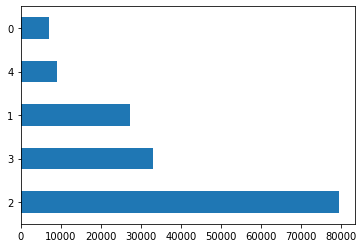

In [33]:
df['Sentiment'].value_counts().plot(kind='barh')

The sentiment labels are:

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [34]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(156060, 512)

In [35]:
from transformers import BertTokenizer

In [37]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [39]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len,truncation = True, padding='max_length', add_special_tokens=True, return_tensors='np') # the special tokens are specific to BERT

In [40]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [41]:
tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [42]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [45]:
#saving it as a numpy binary file
import numpy as np
with open('data/movie-xids.npy','wb') as f:
    np.save(f, tokens['input_ids'])
with open('data/movie-xmask.npy','wb') as f:
    np.save(f, tokens['attention_mask'])

In [47]:
arr = df['Sentiment'].values

In [48]:
arr.shape

(156060,)

In [49]:
arr

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

In [50]:
arr.max() + 1

5

In [51]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [52]:
labels[np.arange(num_samples), arr] = 1

In [53]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [54]:
with open('data/movies_labels.npy', 'wb') as f:
    np.save(f, labels)